In [ ]:
# Use this to install PV-LIB on your system. 
# pip install pvlib 

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openmeteo_requests
import requests_cache
from retry_requests import retry
from sklearn.metrics import mean_squared_error

### Checking for the solar module available in PV_lib. 

### Retriving the Modules with the required company name.

In [3]:
# Retrieve all CEC module models
cec_modules = pvlib.pvsystem.retrieve_sam('cecmod')

# Filter for manufacturers (e.g., Q CELLS, SolarWorld, Heckert)
german_modules = [name for name in cec_modules.keys() if any(brand in name for brand in ['Q_CELLS', 'SolarWorld', 'Heckert', 'Aleo', 'Axitec', 'Schott'])]

print(german_modules)

['Aleo_Solar_P18y250', 'Aleo_Solar_S18y250', 'Aleo_Solar_P18y255', 'Aleo_Solar_S18y255', 'Aleo_Solar_P18y260', 'Aleo_Solar_S18y260', 'Aleo_Solar_P18Y265', 'Aleo_Solar_S18y265', 'Aleo_Solar_S19Y270', 'Aleo_Solar_S79y270', 'Aleo_Solar_P19Y275', 'Aleo_Solar_S19y275', 'Aleo_Solar_S79y275', 'Aleo_Solar_S19y280', 'Aleo_Solar_S59y280', 'Aleo_Solar_S79y280', 'Aleo_Solar_P19Y285', 'Aleo_Solar_S19y285', 'Aleo_Solar_S59y285', 'Aleo_Solar_S79y285', 'Aleo_Solar_P19Y290', 'Aleo_Solar_S19y290', 'Aleo_Solar_S59y290', 'Aleo_Solar_S79Y290', 'Aleo_Solar_P19Y295', 'Aleo_Solar_S19Y295', 'Aleo_Solar_S59Y295', 'Aleo_Solar_S79Y295', 'Aleo_Solar_P19Y300', 'Aleo_Solar_S19Y300', 'Aleo_Solar_S59Y300', 'Aleo_Solar_S79Y300', 'Aleo_Solar_P19Y305', 'Aleo_Solar_S19Y305', 'Aleo_Solar_S59Y305', 'Aleo_Solar_S79Y305', 'Aleo_Solar_P19Y310', 'Aleo_Solar_S19Y310', 'Aleo_Solar_S59Y310', 'Hanwha_Q_CELLS_Q_PRO_G3_240', 'Hanwha_Q_CELLS_Q_PRO_BFR___G3_245', 'Hanwha_Q_CELLS_Q_PRO_G3_245', 'Hanwha_Q_CELLS_Q_PRO_BFR___G3_250', 'Hanw

### Selecting the inverters

### Calculating the inveter base on pannel connection and specifications.

In [ ]:
# checking inverters library
inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

# Convert to DataFrame
df = pd.DataFrame(inverters).T  # Transpose for easier filtering

# for 10 kW capacity range
# the calculation are shown in the Report
filtered_inverters = df[
    (df['Paco'] >= 9500) & (df['Paco'] <= 10500)&  

    (df['Idcmax'] >= 40) 
]

print(filtered_inverters)

                                              Vac        Pso     Paco  \
Yaskawa_Solectria_Solar__PVI_10kW_480__480V_  480  70.141754  10410.0   

                                                      Pdco   Vdco        C0  \
Yaskawa_Solectria_Solar__PVI_10kW_480__480V_  10833.133789  270.0 -0.000002   

                                                    C1        C2       C3  \
Yaskawa_Solectria_Solar__PVI_10kW_480__480V_ -0.000007 -0.000366  0.00007   

                                                Pnt Vdcmax     Idcmax  \
Yaskawa_Solectria_Solar__PVI_10kW_480__480V_  3.123  380.0  40.122718   

                                             Mppt_low Mppt_high   CEC_Date  \
Yaskawa_Solectria_Solar__PVI_10kW_480__480V_    225.0     380.0  2/15/2018   

                                                         CEC_Type  
Yaskawa_Solectria_Solar__PVI_10kW_480__480V_  Utility Interactive  


In [ ]:
# Get the module paramaters
module_params = pvlib.pvsystem.retrieve_sam('cecmod')['Aleo_Solar_P18y250']
inverter_params = pvlib.pvsystem.retrieve_sam('cecinverter')['Yaskawa_Solectria_Solar__PVI_10kW_480__480V_']
print(module_params)


Technology           Multi-c-Si
Bifacial                      0
STC                     249.672
PTC                       224.7
A_c                       1.643
Length                     1.66
Width                      0.99
N_s                          60
I_sc_ref                   8.76
V_oc_ref                   37.5
I_mp_ref                   8.24
V_mp_ref                   30.3
alpha_sc               0.003854
beta_oc                -0.11775
T_NOCT                     47.5
a_ref                   1.51423
I_L_ref                8.766827
I_o_ref                     0.0
R_s                    0.329448
R_sh_ref             422.752747
Adjust                 8.786825
gamma_r                   -0.43
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Aleo_Solar_P18y250, dtype: object


In [6]:
print(inverter_params)

Vac                          480
Pso                    70.141754
Paco                     10410.0
Pdco                10833.133789
Vdco                       270.0
C0                     -0.000002
C1                     -0.000007
C2                     -0.000366
C3                       0.00007
Pnt                        3.123
Vdcmax                     380.0
Idcmax                 40.122718
Mppt_low                   225.0
Mppt_high                  380.0
CEC_Date               2/15/2018
CEC_Type     Utility Interactive
Name: Yaskawa_Solectria_Solar__PVI_10kW_480__480V_, dtype: object


In [7]:
# For the weather data
# Define location (latitude, longitude, altitude)
latitude = 51.75  
longitude = 10.61
altitude = 971  # meters
timezone = 'Etc/GMT+1'  # Time zone

In [ ]:
# Creating a location object
location = pvlib.location.Location(latitude, longitude, tz=timezone, altitude=altitude)

#weather data 
weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude)[0]  

# Converting to Local Time
weather.index = weather.index.tz_convert(timezone)

# Calculating solar position
solar_position = location.get_solarposition(weather.index)

In [ ]:
module_params['pdc0'] = 249.67  # W per module
module_params['gamma_pdc'] = -0.00476  # Temperature coefficient

inverter_params['pdc0'] = 10410  #  10W inverter
inverter_params['eta_inv_nom'] = 0.98  # Inverter efficency
#print(inverter_params)

# Define system parameters
system = {
    'surface_tilt': 60 ,  # tilt angle to get more energy in summer. Calculated for (32, 45, 55, 60)
    'surface_azimuth': 180,  # Facing south
    'module_parameters': module_params,  # module
    'inverter_parameters': inverter_params   #  inverter
}

# Calculate plane of array (POA) irradiance
poa_irradiance = pvlib.irradiance.get_total_irradiance(
    system['surface_tilt'],
    system['surface_azimuth'],
    solar_position['apparent_zenith'],
    solar_position['azimuth'],
    ghi=weather['ghi'], # Global
    dni=weather['dni'], # Direct
    dhi=weather['dhi'], # Diffuse irradiance
    model='isotropic'
)

# 40 Modules
modules_per_string = 10
strings_per_inverter = 4

#When using Sandia model we required Vdc 
""" DC voltage on each MPPT input of the inverter. Required when model=’sandia’  """

# Extract module reference voltage (Vmp)
V_mp_ref = module_params['V_mp_ref']  # Voltage at max power point [V]
#print(V_mp_ref)
# Estimate DC voltage per string (temperature corrected)
v_dc = V_mp_ref * modules_per_string  # DC voltage per string
#print(poa_irradiance['poa_global'])

# Calculate PV power output
temperature = weather['temp_air']  # Air temperature
pv_system = pvlib.pvsystem.PVSystem(module_parameters=system['module_parameters'], modules_per_string = modules_per_string, strings_per_inverter = 4,
                                    inverter_parameters=system['inverter_parameters'],surface_tilt=32, surface_azimuth=180,)
dc_output = pv_system.pvwatts_dc(g_poa_effective=poa_irradiance['poa_global'],  # POA irradiance in W/m²
    temp_cell=weather['temp_air']  # Cell temperature (or module temperature)
)

#print(dc_output)
ac_output = pv_system.get_ac(p_dc=dc_output, v_dc = v_dc,  model="sandia")

# Calculate daily and yearly energy generation
daily_energy = ac_output.resample('D').sum()  # kWh/day
yearly_energy = ac_output.resample('Y').sum().mean()  # kWh/year




Estimated Yearly PV Generation: 827.15 kWh


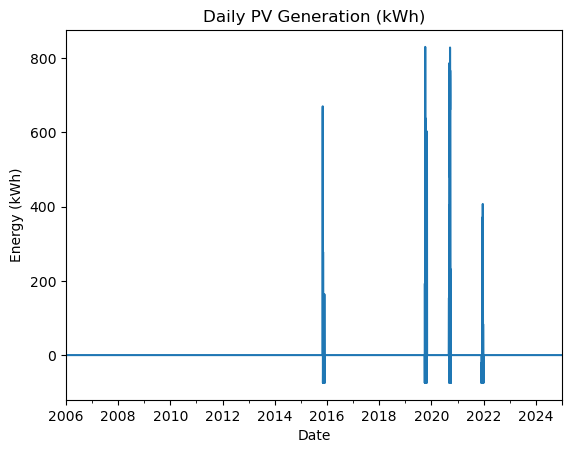

In [63]:
# Results
print(f"Estimated Yearly PV Generation: {yearly_energy:.2f} kWh")


# Daily Energy Generation
daily_energy.plot(title="Daily PV Generation (kWh)", ylabel="Energy (kWh)", xlabel="Date")
plt.show()

In [64]:
yearly_energy

827.1489684612616

In [65]:
ac_output.resample('Y').sum()

2006-12-31 00:00:00+00:00        0.000000
2007-12-31 00:00:00+00:00        0.000000
2008-12-31 00:00:00+00:00        0.000000
2009-12-31 00:00:00+00:00        0.000000
2010-12-31 00:00:00+00:00        0.000000
2011-12-31 00:00:00+00:00        0.000000
2012-12-31 00:00:00+00:00        0.000000
2013-12-31 00:00:00+00:00        0.000000
2014-12-31 00:00:00+00:00        0.000000
2015-12-31 00:00:00+00:00     1630.502538
2016-12-31 00:00:00+00:00        0.000000
2017-12-31 00:00:00+00:00        0.000000
2018-12-31 00:00:00+00:00        0.000000
2019-12-31 00:00:00+00:00     3882.809032
2020-12-31 00:00:00+00:00    10349.135998
2021-12-31 00:00:00+00:00     -146.617167
2022-12-31 00:00:00+00:00        0.000000
2023-12-31 00:00:00+00:00        0.000000
2024-12-31 00:00:00+00:00        0.000000
Freq: A-DEC, dtype: float64

### Due to the weather data we are getting very uneven result annualy.

# Getting the data openmeto data for better weather result. 

In [66]:
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Important Defination.
# Function for frequent use for houlrly data
#https://open-meteo.com/en/docs/historical-weather-api#start_date=1950-01-01&end_date=2023-12-31&hourly=&daily=temperature_2m_mean&timezone=Europe%2FBerlin&models=era5_seamless
def Hourly_open_meteo_data(start_date:str, end_date:str, lat:list, long:list, variable):
	url = "https://archive-api.open-meteo.com/v1/archive"
	params = {
	"latitude": lat,
	"longitude": long,
	"start_date":start_date,
	"end_date": end_date,
	"timezone": "Europe/Berlin",
	"hourly": variable,
	"models": ["era5_seamless"]
	}
	responses = openmeteo.weather_api(url, params=params)
	response = responses[0]
	# Process daily data. The order of variables needs to be the same as requested.
	hourly = response.Hourly()
	hourly_raw_data = hourly.Variables(0).ValuesAsNumpy()

	hourly_data = {"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}
	hourly_data[variable] = hourly_raw_data

	hourly_dataframe = pd.DataFrame(data = hourly_data)

	if hourly_dataframe.empty:
		return print("The daily limit reached")
	return hourly_dataframe

In [67]:
#requesting API for all Irradiance
GHI_Global_Horizontal_Irradiance = Hourly_open_meteo_data("2014-01-01", "2024-12-31",[51.75], [10.61],"shortwave_radiation")
DNI_Direct_Normal_Irradiance = Hourly_open_meteo_data("2014-01-01", "2024-12-31",[51.75], [10.61],"direct_normal_irradiance")
DHI_Diffuse_Horizontal_Irradiance  = Hourly_open_meteo_data("2014-01-01", "2024-12-31",[51.75], [10.61],"diffuse_radiation")


In [68]:
# getting temperture and wind data
temperature_2m = Hourly_open_meteo_data("2014-01-01", "2024-12-31",[51.75], [10.61],"temperature_2m")
wind_speed_10m = Hourly_open_meteo_data("2014-01-01", "2024-12-31",[51.75], [10.61],"wind_speed_10m")


In [69]:
# merge in on data frame
weather_new = GHI_Global_Horizontal_Irradiance.merge(DNI_Direct_Normal_Irradiance, on='date').merge(DHI_Diffuse_Horizontal_Irradiance, on='date').merge(temperature_2m, on='date').merge(wind_speed_10m , on='date')
weather_new.set_index('date', inplace=True) #set index as date/time
weather_new

,shortwave_radiation,direct_normal_irradiance,diffuse_radiation,temperature_2m,wind_speed_10m
date,,,,,
2013-12-31 23:00:00+00:00,0.0,0.0,0.0,-2.8555,10.895576
2014-01-01 00:00:00+00:00,0.0,0.0,0.0,-2.7055,10.661107
2014-01-01 01:00:00+00:00,0.0,0.0,0.0,-2.4055,10.853866
2014-01-01 02:00:00+00:00,0.0,0.0,0.0,-2.4055,10.105681
2014-01-01 03:00:00+00:00,0.0,0.0,0.0,-2.2555,10.182337
...,...,...,...,...,...
2024-12-31 18:00:00+00:00,0.0,0.0,0.0,-1.6055,18.047638
2024-12-31 19:00:00+00:00,0.0,0.0,0.0,-2.1555,19.406637
2024-12-31 20:00:00+00:00,0.0,0.0,0.0,-2.0055,21.010712


In [70]:
weather_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96432 entries, 2013-12-31 23:00:00+00:00 to 2024-12-31 22:00:00+00:00
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   shortwave_radiation       96432 non-null  float32
 1   direct_normal_irradiance  96432 non-null  float32
 2   diffuse_radiation         96432 non-null  float32
 3   temperature_2m            96432 non-null  float32
 4   wind_speed_10m            96432 non-null  float32
dtypes: float32(5)
memory usage: 2.6 MB


### Recalculating the PVlib senario with new weather data

In [71]:
print(weather_new[['shortwave_radiation', 'direct_normal_irradiance', 'diffuse_radiation']].describe())

       shortwave_radiation  direct_normal_irradiance  diffuse_radiation
count         96432.000000              96432.000000       96432.000000
mean            126.375610                139.090454          54.337429
std             195.878998                222.170364          75.061111
min               0.000000                  0.000000           0.000000
25%               0.000000                  0.000000           0.000000
50%               5.000000                  0.000000           5.000000
75%             194.000000                219.631695          98.000000
max             890.000000                920.224854         412.000000


In [72]:
#Recalculating the Output

# Define system parameters
# After correction
solar_position = location.get_solarposition(weather_new.index)

# Calculate plane of array (POA) irradiance
poa_irradiance = pvlib.irradiance.get_total_irradiance(
    system['surface_tilt'],
    system['surface_azimuth'],
    solar_position['apparent_zenith'],
    solar_position['azimuth'],
    ghi=weather_new["shortwave_radiation"],
    dni=weather_new["direct_normal_irradiance"],
    dhi=weather_new["diffuse_radiation"],
    model='isotropic'
)

# Extract module reference voltage (Vmp)
V_mp_ref = module_params['V_mp_ref']  # Voltage at max power point [V]

# Estimate DC voltage per string (temperature corrected)
v_dc = V_mp_ref * modules_per_string  # DC voltage per string

#previouly we were using atmospher Temp as module temp
# Compute module temperature using an appropriate model
temp_cell = pvlib.temperature.sapm_cell(
    poa_irradiance['poa_global'], weather_new["temperature_2m"], wind_speed=weather_new["wind_speed_10m"],
    **pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
)
# PV system is defined early
# Calculate DC power with loss factor
dc_output = pv_system.pvwatts_dc(poa_irradiance['poa_global'], temp_cell)
dc_output_corrected = dc_output * 0.77  # Apply 23% losses for cables, soiling, mismatch,weather etc

# Apply inverter clipping & conversion efficiency
ac_output = pv_system.get_ac(p_dc=dc_output_corrected,v_dc=v_dc, model="sandia")





In [73]:
# Compute energy generation
daily_energy = ac_output.resample('D').sum()  
yearly_energy = ac_output.resample('Y').sum().mean()  

# Print corrected results
print(f"Estimated Yearly PV Generation: {yearly_energy:.2f} kWh")

Estimated Yearly PV Generation: 16683.60 kWh


In [75]:
energy_year_kwp = yearly_energy/10 # 10 installed capacity 
energy_year_kwp

1668.3599386531507

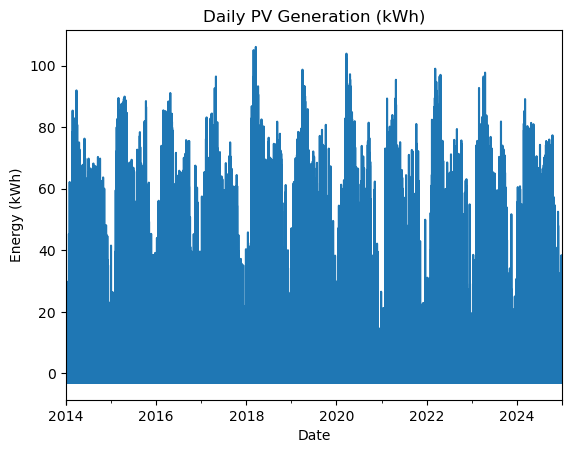

In [76]:
winter_energy = ac_output[ac_output.index.month.isin([10, 11, 12, 1, 2, 3])].resample('D').sum().mean()
summer_energy = ac_output[ac_output.index.month.isin([5, 4, 6, 7, 8, 9])].resample('D').sum().mean()

# Plot Daily Energy Generation
ac_output.plot(title="Daily PV Generation (kWh)", ylabel="Energy (kWh)", xlabel="Date")
plt.show()

In [77]:
print(f"Avergae daily energy in winter is {winter_energy}")
print(f"Average daily energy in summer is {summer_energy}")

Avergae daily energy in winter is -0.9053750268310292
Average daily energy in summer is 53.13918010198435


### Solve the negative output
### it it due to zero value available for Global radiation.

In [79]:
winter_energy_days = ac_output[weather_new.index.month.isin([10, 11, 12, 1, 2, 3])].resample('D').mean()

In [80]:
winter_energy_days

date
2013-12-31 00:00:00+00:00   -3.123000
2014-01-01 00:00:00+00:00   -3.123000
2014-01-02 00:00:00+00:00   -3.123000
2014-01-03 00:00:00+00:00   -3.123000
2014-01-04 00:00:00+00:00   -3.123000
                               ...   
2024-12-27 00:00:00+00:00   -3.123000
2024-12-28 00:00:00+00:00    2.465348
2024-12-29 00:00:00+00:00   -3.123000
2024-12-30 00:00:00+00:00   -3.123000
2024-12-31 00:00:00+00:00   -2.034188
Freq: D, Length: 4019, dtype: float64

<Axes: title={'center': 'Daily PV Generation (kWh)'}, xlabel='Date', ylabel='Energy (kWh)'>

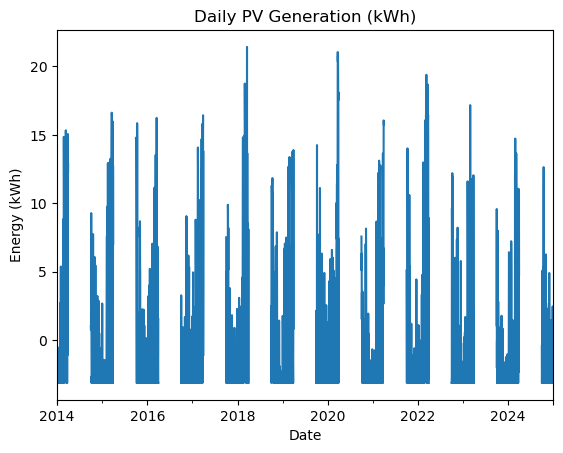

In [81]:
winter_energy_days.plot(title="Daily PV Generation (kWh)", ylabel="Energy (kWh)", xlabel="Date")

### cliping of the non negative values

<Axes: title={'center': 'Daily PV Generation (kWh)'}, xlabel='Date', ylabel='Energy (kWh)'>

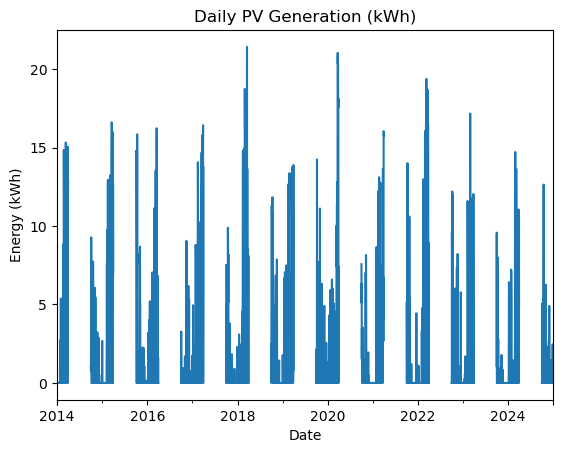

In [82]:
winter_energy_days = winter_energy_days.clip(lower=0)
winter_energy_days.plot(title="Daily PV Generation (kWh)", ylabel="Energy (kWh)", xlabel="Date")

In [83]:
ac_output_clipped = ac_output.clip(lower=0)
winter_energy_days_clipped = ac_output_clipped[weather_new.index.month.isin([10, 11, 12, 1, 2, 3])].resample('D').sum().mean()
winter_energy_days_clipped
#winter_energy_days_clipped.plot(title="Daily PV Generation (kWh)", ylabel="Energy (kWh)", xlabel="Date")


33.357486132661386

In [84]:
print(f"Avergae daily energy in winter is {winter_energy_days_clipped}")
print(f"Average daily energy in summer is {summer_energy}")

Avergae daily energy in winter is 33.357486132661386
Average daily energy in summer is 53.13918010198435


In [85]:
ac_output.resample('Y').sum()

date
2013-12-31 00:00:00+00:00       -3.123000
2014-12-31 00:00:00+00:00    13442.181623
2015-12-31 00:00:00+00:00    17947.383065
2016-12-31 00:00:00+00:00    16204.395123
2017-12-31 00:00:00+00:00    11838.833110
2018-12-31 00:00:00+00:00    28047.933392
2019-12-31 00:00:00+00:00    22367.965606
2020-12-31 00:00:00+00:00    21939.072104
2021-12-31 00:00:00+00:00    10424.319026
2022-12-31 00:00:00+00:00    23670.120192
2023-12-31 00:00:00+00:00    16169.828370
2024-12-31 00:00:00+00:00    18154.284027
Freq: A-DEC, dtype: float64